In [51]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import re
import itertools
import os
from os import path

# Experiment Setup

### GPU Info and NUMA Info
```
hand32@node0:~/experiments/hugepages/cloudlab/d8545$ nvidia-smi
Tue Oct 15 16:16:12 2024
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB           On | 00000000:01:00.0 Off |                    0 |
| N/A   26C    P0               50W / 400W|      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM4-40GB           On | 00000000:41:00.0 Off |                    0 |
| N/A   25C    P0               49W / 400W|      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   2  NVIDIA A100-SXM4-40GB           On | 00000000:81:00.0 Off |                    0 |
| N/A   27C    P0               50W / 400W|      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB           On | 00000000:C1:00.0 Off |                    0 |
| N/A   25C    P0               48W / 400W|      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+

+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+

hand32@node0:~/cuda-samples-12.1/Samples/0_Introduction/vectorAdd$ numactl --hardware
available: 8 nodes (0-7)
node 0 cpus: 0 1 2 3 4 5 48 49 50 51 52 53
node 0 size: 64069 MB
node 0 free: 59660 MB
node 1 cpus: 6 7 8 9 10 11 54 55 56 57 58 59
node 1 size: 64508 MB
node 1 free: 63617 MB
node 2 cpus: 12 13 14 15 16 17 60 61 62 63 64 65
node 2 size: 64508 MB
node 2 free: 54826 MB
node 3 cpus: 18 19 20 21 22 23 66 67 68 69 70 71
node 3 size: 64496 MB
node 3 free: 63441 MB
node 4 cpus: 24 25 26 27 28 29 72 73 74 75 76 77
node 4 size: 64508 MB
node 4 free: 64179 MB
node 5 cpus: 30 31 32 33 34 35 78 79 80 81 82 83
node 5 size: 64508 MB
node 5 free: 64047 MB
node 6 cpus: 36 37 38 39 40 41 84 85 86 87 88 89
node 6 size: 64456 MB
node 6 free: 64038 MB
node 7 cpus: 42 43 44 45 46 47 90 91 92 93 94 95
node 7 size: 64502 MB
node 7 free: 64027 MB
node distances:
node   0   1   2   3   4   5   6   7
  0:  10  12  12  12  32  32  32  32
  1:  12  10  12  12  32  32  32  32
  2:  12  12  10  12  32  32  32  32
  3:  12  12  12  10  32  32  32  32
  4:  32  32  32  32  10  12  12  12
  5:  32  32  32  32  12  10  12  12
  6:  32  32  32  32  12  12  10  12
  7:  32  32  32  32  12  12  12  10
```

## Details
```
The node has 4 GPUs and 8 different NUMA regions with ~60 GB of DRAM each. The experiment setup is to allocate 40 GB of 1 GB pages per NUMA and measure the HostToDevice and DeviceToHost transfer speeds 
```

In [66]:
CUDAN = np.arange(0, 1)
NUMAN = np.arange(0, 8)
ITERN = np.arange(0, 10)

combinations = list(itertools.product(CUDAN, NUMAN))


In [67]:
def parseLog(loc):
    hToD1 = 0
    hToD2 = 0
    dToH1 = 0
    with open(loc) as file:
        for line in file:
            if 'HtoD' in line:
                text = re.split(r'\s{2,}', line.strip())
                #print(text)
                if hToD1 != 0:
                    hToD2 = int(text[1].replace(',', ''))
                else:
                    hToD1 = int(text[1].replace(',', ''))
                #print(line.strip())
            elif 'DtoH' in line:
                text = re.split(r'\s{2,}', line.strip())
                dToH1 = int(text[1].replace(',', ''))
                #print(line.strip())
    return hToD1, hToD2, dToH1


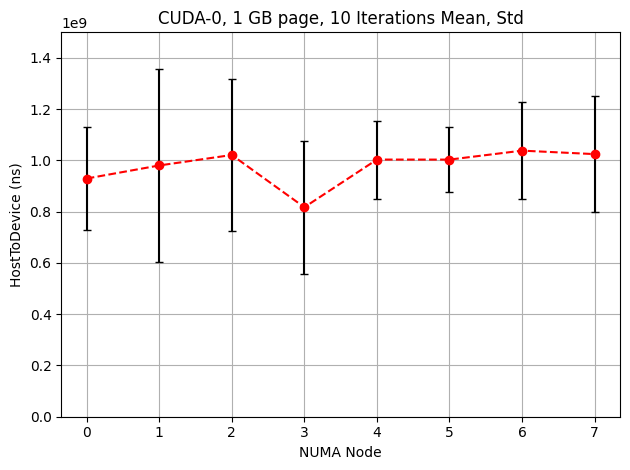

In [81]:
cudan = 0
cudanHToD1mean = []
cudanHToD1std = []

cudanHToD2mean = []
cudanHToD2std = []

cudanDToH1mean = []
cudaDToH1std = []

for numan in NUMAN:    
    arrHToD1 = []
    arrHToD2 = []
    arrDToH1 = []
    for itern in ITERN:
        loc=f"vaddProf.CUDA-{cudan}.NUMA-{numan}.ITER-{itern}.log"
        if not path.exists(loc):
            break
        #print(f"Processing: {loc}")
        hd1, hd2, dh1 = parseLog(loc)
        arrHToD1.append(hd1)
        arrHToD2.append(hd2)
        arrDToH1.append(dh1)
    meanHToD1 = round(np.mean(arrHToD1), 2)
    stdHToD1 = round(np.std(arrHToD1), 2)
    meanHToD2 = round(np.mean(arrHToD2), 2)
    stdHToD2 = round(np.std(arrHToD2), 2)
    meanDToH1 = round(np.mean(arrDToH1), 2)
    stdDToH1 = round(np.std(arrDToH1), 2)

    cudanHToD1mean.append(meanHToD1)
    cudanHToD1std.append(stdHToD1)
    cudanHToD2mean.append(meanHToD2)
    cudanHToD2std.append(stdHToD2)
    cudanDToH1mean.append(meanDToH1)                    
    cudaDToH1std.append(stdDToH1)
    
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(cudanHToD1mean)), cudanHToD1mean, yerr=cudanHToD1std, capsize=3, fmt="r--o", ecolor = "black")
ax.set_xlabel('NUMA Node') 
ax.set_ylabel('HostToDevice (ns)')
ax.set_ylim(bottom=0,top=1500000000)
ax.set_title(f"CUDA-{cudan}, 1 GB page, 10 Iterations Mean, Std")
plt.grid()
plt.tight_layout()

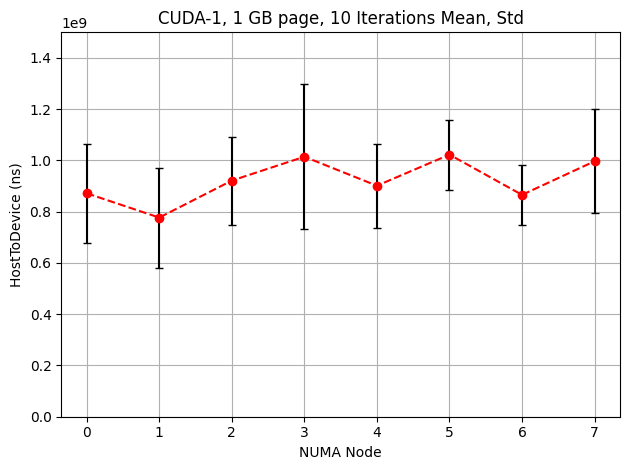

In [80]:
cudan = 1
cudanHToD1mean = []
cudanHToD1std = []

cudanHToD2mean = []
cudanHToD2std = []

cudanDToH1mean = []
cudaDToH1std = []

for numan in NUMAN:    
    arrHToD1 = []
    arrHToD2 = []
    arrDToH1 = []
    for itern in ITERN:
        loc=f"vaddProf.CUDA-{cudan}.NUMA-{numan}.ITER-{itern}.log"
        if not path.exists(loc):
            break
        #print(f"Processing: {loc}")
        hd1, hd2, dh1 = parseLog(loc)
        arrHToD1.append(hd1)
        arrHToD2.append(hd2)
        arrDToH1.append(dh1)
    meanHToD1 = round(np.mean(arrHToD1), 2)
    stdHToD1 = round(np.std(arrHToD1), 2)
    meanHToD2 = round(np.mean(arrHToD2), 2)
    stdHToD2 = round(np.std(arrHToD2), 2)
    meanDToH1 = round(np.mean(arrDToH1), 2)
    stdDToH1 = round(np.std(arrDToH1), 2)

    cudanHToD1mean.append(meanHToD1)
    cudanHToD1std.append(stdHToD1)
    cudanHToD2mean.append(meanHToD2)
    cudanHToD2std.append(stdHToD2)
    cudanDToH1mean.append(meanDToH1)                    
    cudaDToH1std.append(stdDToH1)
    
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(cudanHToD1mean)), cudanHToD1mean, yerr=cudanHToD1std, capsize=3, fmt="r--o", ecolor = "black")
ax.set_xlabel('NUMA Node') 
ax.set_ylabel('HostToDevice (ns)')
ax.set_ylim(bottom=0,top=1500000000)
ax.set_title(f"CUDA-{cudan}, 1 GB page, 10 Iterations Mean, Std")
plt.grid()
plt.tight_layout()

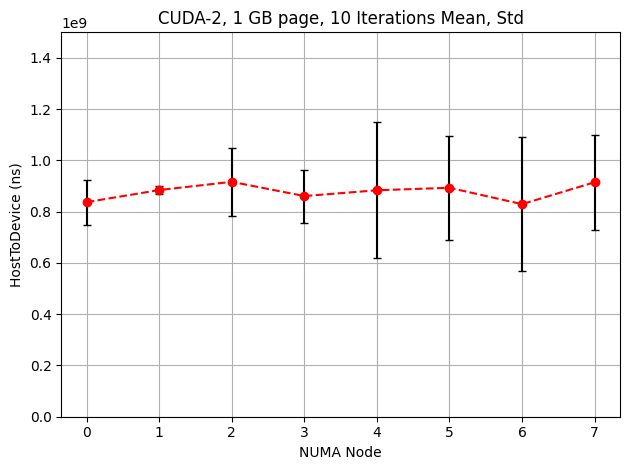

In [79]:
cudan = 2
cudanHToD1mean = []
cudanHToD1std = []

cudanHToD2mean = []
cudanHToD2std = []

cudanDToH1mean = []
cudaDToH1std = []

for numan in NUMAN:    
    arrHToD1 = []
    arrHToD2 = []
    arrDToH1 = []
    for itern in ITERN:
        loc=f"vaddProf.CUDA-{cudan}.NUMA-{numan}.ITER-{itern}.log"
        if not path.exists(loc):
            break
        #print(f"Processing: {loc}")
        hd1, hd2, dh1 = parseLog(loc)
        arrHToD1.append(hd1)
        arrHToD2.append(hd2)
        arrDToH1.append(dh1)
    meanHToD1 = round(np.mean(arrHToD1), 2)
    stdHToD1 = round(np.std(arrHToD1), 2)
    meanHToD2 = round(np.mean(arrHToD2), 2)
    stdHToD2 = round(np.std(arrHToD2), 2)
    meanDToH1 = round(np.mean(arrDToH1), 2)
    stdDToH1 = round(np.std(arrDToH1), 2)

    cudanHToD1mean.append(meanHToD1)
    cudanHToD1std.append(stdHToD1)
    cudanHToD2mean.append(meanHToD2)
    cudanHToD2std.append(stdHToD2)
    cudanDToH1mean.append(meanDToH1)                    
    cudaDToH1std.append(stdDToH1)
    
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(cudanHToD1mean)), cudanHToD1mean, yerr=cudanHToD1std, capsize=3, fmt="r--o", ecolor = "black")
ax.set_xlabel('NUMA Node') 
ax.set_ylabel('HostToDevice (ns)')
ax.set_ylim(bottom=0,top=1500000000)
ax.set_title(f"CUDA-{cudan}, 1 GB page, 10 Iterations Mean, Std")
plt.grid()
plt.tight_layout()

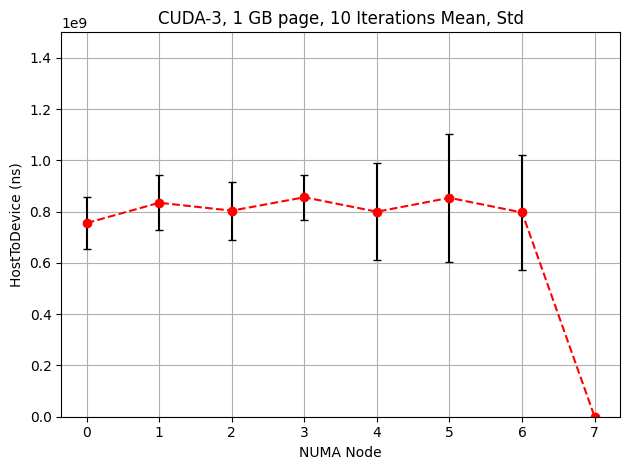

In [78]:
cudan = 3
cudanHToD1mean = []
cudanHToD1std = []

cudanHToD2mean = []
cudanHToD2std = []

cudanDToH1mean = []
cudaDToH1std = []

for numan in NUMAN:    
    arrHToD1 = []
    arrHToD2 = []
    arrDToH1 = []
    for itern in ITERN:
        loc=f"vaddProf.CUDA-{cudan}.NUMA-{numan}.ITER-{itern}.log"
        if not path.exists(loc):
            break
        #print(f"Processing: {loc}")
        hd1, hd2, dh1 = parseLog(loc)
        arrHToD1.append(hd1)
        arrHToD2.append(hd2)
        arrDToH1.append(dh1)
    meanHToD1 = round(np.mean(arrHToD1), 2)
    stdHToD1 = round(np.std(arrHToD1), 2)
    meanHToD2 = round(np.mean(arrHToD2), 2)
    stdHToD2 = round(np.std(arrHToD2), 2)
    meanDToH1 = round(np.mean(arrDToH1), 2)
    stdDToH1 = round(np.std(arrDToH1), 2)

    cudanHToD1mean.append(meanHToD1)
    cudanHToD1std.append(stdHToD1)
    cudanHToD2mean.append(meanHToD2)
    cudanHToD2std.append(stdHToD2)
    cudanDToH1mean.append(meanDToH1)                    
    cudaDToH1std.append(stdDToH1)
    
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(cudanHToD1mean)), cudanHToD1mean, yerr=cudanHToD1std, capsize=3, fmt="r--o", ecolor = "black")
ax.set_xlabel('NUMA Node') 
ax.set_ylabel('HostToDevice (ns)')
ax.set_ylim(bottom=0,top=1500000000)
ax.set_title(f"CUDA-{cudan}, 1 GB page, 10 Iterations Mean, Std")
plt.grid()
plt.tight_layout()